In [1]:
# Version 67
# From https://ungoogled-software.github.io/ungoogled-chromium-binaries/releases/linux_portable/64bit/
!wget -q https://github.com/Eloston/ungoogled-chromium-binaries/releases/download/67.0.3396.87-2/ungoogled-chromium_67.0.3396.87-2_linux.tar.xz
!tar -xf ungoogled-chromium_67.0.3396.87-2_linux.tar.xz

# From https://chromedriver.storage.googleapis.com/index.html
!wget -q https://chromedriver.storage.googleapis.com/2.41/chromedriver_linux64.zip
!unzip -o chromedriver_linux64.zip -d ./ungoogled-chromium_67.0.3396.87-1_linux

Archive:  chromedriver_linux64.zip
  inflating: ./ungoogled-chromium_67.0.3396.87-1_linux/chromedriver  


In [1]:
from selenium import webdriver
import os

def save_page(url,image):
    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--disable-gpu')
    chrome_options.add_argument('--incognito')
    chrome_options.add_argument('log-level=3')
    chrome_options.add_argument("--disable-dev-shm-usage")
    chrome_options.add_argument("--no-sandbox")
    chrome_driver = os.getcwd() +"/ungoogled-chromium_67.0.3396.87-1_linux/chromedriver"

    driver = webdriver.Chrome(options=chrome_options, executable_path=chrome_driver)
    #driver.set_page_load_timeout(6)
    #driver.set_script_timeout(6)
    driver.get(url)
    #time.sleep(0.5)
    driver.save_screenshot(image)
    driver.quit()
    
save_page('https://www.google.com','screenshot.png')

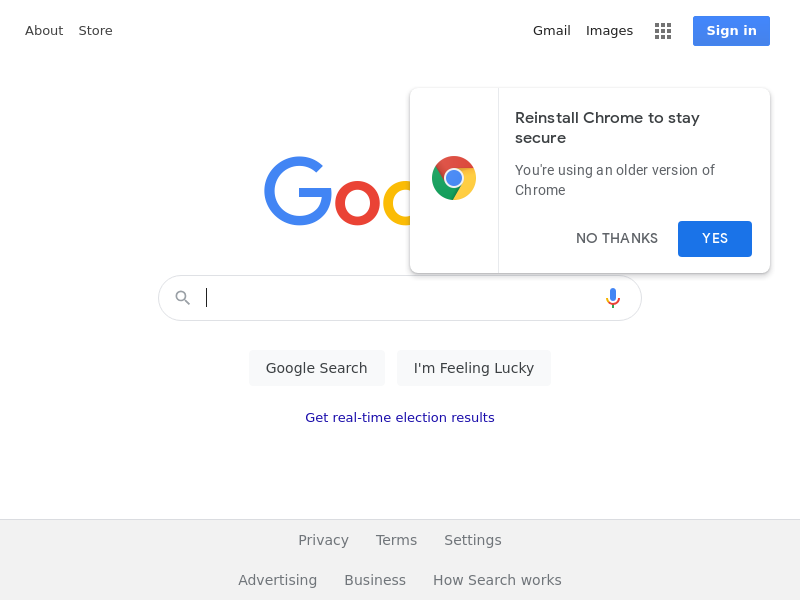

In [2]:
from IPython.display import Image
Image('screenshot.png')

# Udemy Training

> console $$() css selector
> $$("input[id='ipt1']")
> $x() xpath selector
> $x("//button[@id='b4']")
> $x("//b[text()='Product 1']/../../p")[0].innerText


In [1]:
from selenium import webdriver
from IPython.display import Image

import os

In [2]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--disable-gpu')
chrome_options.add_argument('--incognito')
chrome_options.add_argument('log-level=3')
chrome_options.add_argument("--disable-dev-shm-usage")
chrome_options.add_argument("--no-sandbox")
chrome_driver = os.getcwd() +"/ungoogled-chromium_67.0.3396.87-1_linux/chromedriver"
browser = webdriver.Chrome(options=chrome_options, executable_path=chrome_driver)
browser.get('https://techstepacademy.com/training-ground')

In [8]:
butn4_element = browser.find_element_by_xpath("//button[@id='b4']")
butn4_element.click()

In [12]:
button_element = browser.find_element_by_css_selector('button[name="butn1"]')
button_element.click()

In [30]:
input_element = browser.find_element_by_css_selector('input[id="ipt1"]')
input_element.send_keys('My first Automation')

In [13]:
browser.switch_to.alert.text

'You clickedButton1.'

In [14]:
browser.switch_to.alert.dismiss()

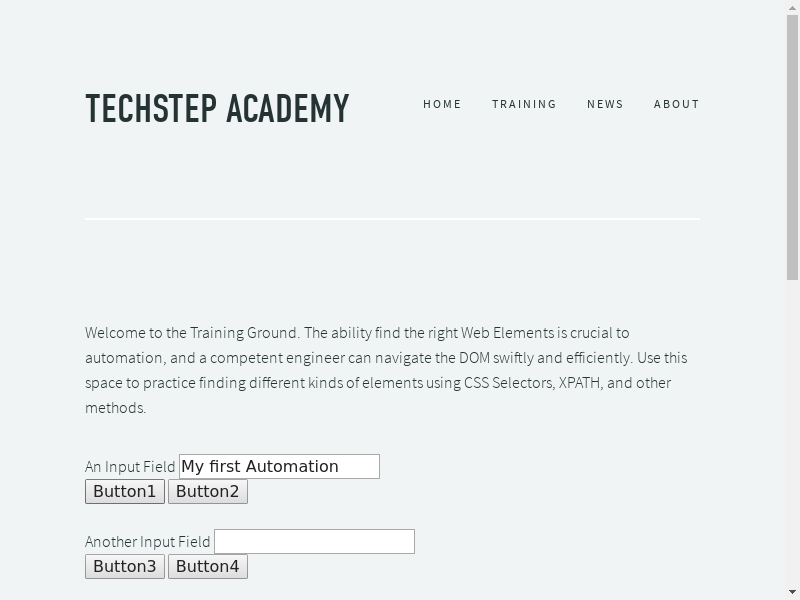

In [41]:
browser.save_screenshot('test.png')
Image('test.png')

In [ ]:
browser.quit()

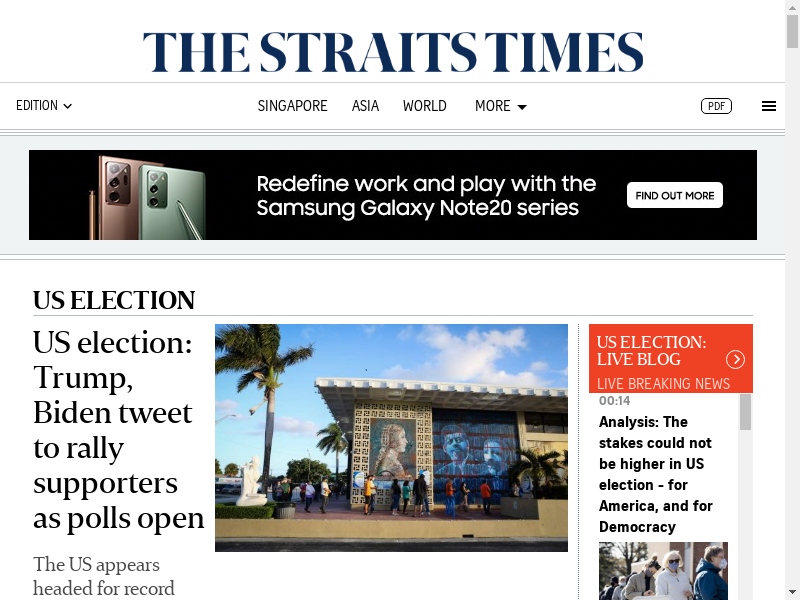

In [3]:
Image('screenshot.png')

In [1]:
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
from datetime import datetime
import time
import re
import logging
import traceback

GM_WEBPAGE = 'https://www.google.com/maps/'
MAX_WAIT = 10
MAX_RETRY = 5
MAX_SCROLLS = 40

class GoogleMapsScraper:

    def __init__(self, debug=False):
        self.debug = debug
        self.driver = self.__get_driver()
        self.logger = self.__get_logger()

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, tb):
        if exc_type is not None:
            traceback.print_exception(exc_type, exc_value, tb)

        self.driver.close()
        self.driver.quit()

        return True

    def sort_by_date(self, url):
        self.driver.get(url)
        wait = WebDriverWait(self.driver, MAX_WAIT)

        # open dropdown menu
        clicked = False
        tries = 0
        while not clicked and tries < MAX_RETRY:
            try:
                #if not self.debug:
                #    menu_bt = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, 'div.cYrDcjyGO77__container')))
                #else:
                menu_bt = wait.until(EC.element_to_be_clickable((By.XPATH, '//button[@data-value=\'Sort\']')))
                menu_bt.click()

                clicked = True
                time.sleep(3)
            except Exception as e:
                tries += 1
                self.logger.warn('Failed to click recent button')

            # failed to open the dropdown
            if tries == MAX_RETRY:
                return -1

        # second element of the list: most recent
        recent_rating_bt = self.driver.find_elements_by_xpath('//li[@role=\'menuitemradio\']')[1]
        recent_rating_bt.click()

        # wait to load review (ajax call)
        time.sleep(5)

        return 0

    def get_reviews(self, offset):

        # scroll to load reviews
        self.__scroll()

        # wait for other reviews to load (ajax)
        time.sleep(4)

        # expand review text
        self.__expand_reviews()

        # parse reviews
        response = BeautifulSoup(self.driver.page_source, 'html.parser')
        rblock = response.find_all('div', class_='section-review-content')
        parsed_reviews = []
        for index, review in enumerate(rblock):
            if index >= offset:
                parsed_reviews.append(self.__parse(review))

        return parsed_reviews


    def get_account(self, url):

        self.driver.get(url)

        # ajax call also for this section
        time.sleep(4)

        resp = BeautifulSoup(self.driver.page_source, 'html.parser')

        place_data = self.__parse_place(resp)

        return place_data


    def __parse(self, review):

        item = {}

        id_review = review.find('button', class_='section-review-action-menu')['data-review-id']
        username = review.find('div', class_='section-review-title').find('span').text

        try:
            review_text = self.__filter_string(review.find('span', class_='section-review-text').text)
        except Exception as e:
            review_text = None

        rating = float(review.find('span', class_='section-review-stars')['aria-label'].split(' ')[1])
        relative_date = review.find('span', class_='section-review-publish-date').text

        try:
            n_reviews_photos = review.find('div', class_='section-review-subtitle').find_all('span')[1].text
            metadata = n_reviews_photos.split('\xe3\x83\xbb')
            if len(metadata) == 3:
                n_photos = int(metadata[2].split(' ')[0].replace('.', ''))
            else:
                n_photos = 0

            idx = len(metadata)
            n_reviews = int(metadata[idx - 1].split(' ')[0].replace('.', ''))

        except Exception as e:
            n_reviews = 0
            n_photos = 0

        user_url = review.find('a')['href']

        item['id_review'] = id_review
        item['caption'] = review_text

        # depends on language, which depends on geolocation defined by Google Maps
        # custom mapping to transform into date shuold be implemented
        item['relative_date'] = relative_date

        # store datetime of scraping and apply further processing to calculate
        # correct date as retrieval_date - time(relative_date)
        item['retrieval_date'] = datetime.now()
        item['rating'] = rating
        item['username'] = username
        item['n_review_user'] = n_reviews
        item['n_photo_user'] = n_photos
        item['url_user'] = user_url

        return item


    def __parse_place(self, response):

        place = {}
        try:
            place['overall_rating'] = float(response.find('div', class_='gm2-display-2').text.replace(',', '.'))
        except:
            place['overall_rating'] = 'NOT FOUND'

        try:
            place['n_reviews'] = int(response.find('div', class_='gm2-caption').text.replace('.', '').replace(',','').split(' ')[0])
        except:
            place['n_reviews'] = 0
            
        return place

    # expand review description
    def __expand_reviews(self):
        # use XPath to load complete reviews
        links = self.driver.find_elements_by_xpath('//button[@class=\'section-expand-review blue-link\']')
        for l in links:
            l.click()
        time.sleep(2)


    def __scroll(self):
        scrollable_div = self.driver.find_element_by_css_selector('div.section-layout.section-scrollbox.scrollable-y.scrollable-show')
        self.driver.execute_script('arguments[0].scrollTop = arguments[0].scrollHeight', scrollable_div)


    def __get_logger(self):
        # create logger
        logger = logging.getLogger('googlemaps-scraper')
        logger.setLevel(logging.DEBUG)

        # create console handler and set level to debug
        fh = logging.FileHandler('gm-scraper.log')
        fh.setLevel(logging.DEBUG)

        # create formatter
        formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')

        # add formatter to ch
        fh.setFormatter(formatter)

        # add ch to logger
        logger.addHandler(fh)

        return logger


    def __get_driver(self, debug=False):
        options = Options()

        if not self.debug:
            options.add_argument("--headless")
        else:
            options.add_argument("--window-size=1366,768")

        options.add_argument("--disable-notifications")
        options.add_argument("--lang=en-GB")
        input_driver = webdriver.Chrome(chrome_options=options)

        return input_driver


    # util function to clean special characters
    def __filter_string(self, str):
        strOut = str.replace('\r', ' ').replace('\n', ' ').replace('\t', ' ')
        return strOut

In [ ]:
from googlemaps import GoogleMapsScraper
from datetime import datetime, timedelta
import argparse
import csv

HEADER = ['id_review', 'caption', 'relative_date', 'retrieval_date', 'rating', 'username', 'n_review_user', 'n_photo_user', 'url_user']
HEADER_W_SOURCE = ['id_review', 'caption', 'relative_date','retrieval_date', 'rating', 'username', 'n_review_user', 'n_photo_user', 'url_user', 'url_source']

def csv_writer(source_field, path='data/', outfile='gm_reviews.csv'):
    targetfile = open(path + outfile, mode='w', encoding='utf-8', newline='\n')
    writer = csv.writer(targetfile, quoting=csv.QUOTE_MINIMAL)

    if source_field:
        h = HEADER_W_SOURCE
    else:
        h = HEADER
    writer.writerow(h)

    return writer


if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Google Maps reviews scraper.')
    parser.add_argument('--N', type=int, default=100, help='Number of reviews to scrape')
    parser.add_argument('--i', type=str, default='urls.txt', help='target URLs file')
    parser.add_argument('--place', dest='place', action='store_true', help='Scrape place metadata')
    parser.add_argument('--debug', dest='debug', action='store_true', help='Run scraper using browser graphical interface')
    parser.add_argument('--source', dest='source', action='store_true', help='Add source url to CSV file (for multiple urls in a single file)')
    parser.set_defaults(place=False, debug=False, source=False)

    args = parser.parse_args()

    # store reviews in CSV file
    writer = csv_writer(args.source)

    with GoogleMapsScraper(debug=args.debug) as scraper:
        with open(args.i, 'r') as urls_file:
            for url in urls_file:

                if args.place:
                    print(scraper.get_account(url))
                else:
                    error = scraper.sort_by_date(url)
                    if error == 0:

                        n = 0
                        while n < args.N:
                            reviews = scraper.get_reviews(n)

                            for r in reviews:
                                row_data = list(r.values())
                                if args.source:
                                    row_data.append(url)

                                writer.writerow(row_data)

                            n += len(reviews)